In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import os
import glob
import json
import geopandas as gp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from scipy import stats



# Data

In [2]:
data_path = '../../data/'
start_wave1 = '2020-03-01'
end_wave1 = '2020-06-04'

In [ ]:
'../../data/raw/GIS/NIS_name.csv'

In [289]:
NIS_arrondissement = pd.read_csv(data_path+'raw/GIS/NIS_arrondissement.csv')
inhabitants = pd.read_csv(data_path+'raw/GIS/inhabitants.csv')
inhabitants.NIS = inhabitants.NIS.astype(str)
NIS_name = pd.read_csv(data_path+'raw/GIS/NIS_name.csv', dtype=str)
NIS_to_name = {x:y for x,y in zip(NIS_name.NIS, NIS_name.name)}

In [7]:
# Read shapefiles
provinces = gp.read_file(data_path+"raw/GIS/shapefiles/BE/AD_4_Province.shp")
provinces['area'] = provinces.geometry.area
arrondissementen = gp.read_file(data_path+"raw/GIS/shapefiles/BE/Arrondissements.shp")
arrondissementen['area'] = arrondissementen.geometry.area
municipalities = gp.read_file('../../data/raw/GIS/shapefiles/BE/AD_2_Municipality.shp')
municipalities['area'] = municipalities.geometry.area
municipalities = municipalities[['NISCode', 'geometry','area']].rename(columns={'NISCode':'NIS'})

In [267]:
arr_age_structure = pd.read_csv(data_path+'interim/demographic/age_structure_per_arrondissement.csv')
arr_age_structure.NIS = arr_age_structure.NIS.astype(str)
arr_age_dataset = arr_age_structure.groupby('NIS').apply(lambda x: np.repeat(x.age, x.number))

arr_age_over_60 = arr_age_dataset.groupby('NIS').apply(lambda x: (x>60).sum()/len(x)).reset_index().rename(columns={'age':'age_over_60'})
arr_median_age = arr_age_dataset.groupby('NIS').median().reset_index().rename(columns={'age':'median_age'})
arr_age_skewness = arr_age_dataset.groupby('NIS').apply(lambda x: stats.skew(x)).reset_index().rename(columns={'age':'skewness'})

In [268]:
mun_age_structure = pd.read_csv(data_path+'interim/demographic/age_structure_per_municipality.csv')
mun_age_structure.NIS = mun_age_structure.NIS.astype(str)
mun_age_dataset = mun_age_structure.groupby('NIS').apply(lambda x: np.repeat(x.age, x.number))

mun_age_over_60 = mun_age_dataset.groupby('NIS').apply(lambda x: (x>60).sum()/len(x)).reset_index().rename(columns={'age':'age_over_60'})
mun_median_age = mun_age_dataset.groupby('NIS').median().reset_index().rename(columns={'age':'median_age'})
mun_age_skewness = mun_age_dataset.groupby('NIS').apply(lambda x: stats.skew(x)).reset_index().rename(columns={'age':'skewness'})

https://statbel.fgov.be/nl/open-data/census-2011-leeftijd-arbeidsmarktsituatie-opleidingsniveau-verblijfplaats-0

In [ ]:
socio_economic = pd.read_csv(data_path+'raw/census_2011/socio_economic.txt', delimiter='|')

In [ ]:
socio_economic

# Timeseries arrondissement-level

In [17]:
nonpublic_ts_arr = pd.read_csv(data_path+'interim/non_public/all_nonpublic_timeseries_arr.csv', 
                               parse_dates=['DATE'], dtype={'NIS_arr':str})


In [30]:
hospitalised_arr =  nonpublic_ts_arr.groupby('NIS_arr').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].hospitalised_IN.agg([sum, max])).rename(
                      columns={'sum':'hosp_sum','max':'hosp_max'}).reset_index()

confirmed_arr =  nonpublic_ts_arr.groupby('NIS_arr').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].confirmed_cases.agg([sum, max])).rename(
                      columns={'sum':'conf_sum','max':'conf_max'}).reset_index()

deceased_hosp_arr =  nonpublic_ts_arr.groupby('NIS_arr').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].deceased_hosp.agg([sum, max])).rename(
                      columns={'sum':'deceased_sum','max':'deceased_max'}).reset_index()

In [34]:
data_cols = ['deceased_sum', 'deceased_max', 'conf_sum', 'conf_max','hosp_sum', 'hosp_max']
COVID_data_arr = pd.merge(hospitalised_arr, inhabitants[['NIS','inhabitants']], left_on='NIS_arr', right_on='NIS').drop(columns='NIS')
COVID_data_arr = pd.merge(confirmed_arr, COVID_data_arr, on='NIS_arr')
COVID_data_arr = pd.merge(deceased_hosp_arr, COVID_data_arr, on='NIS_arr')
COVID_per_100k_arr = COVID_data_arr.copy()
COVID_per_100k_arr[data_cols] = COVID_per_100k_arr[data_cols]/COVID_per_100k_arr[['inhabitants']].values*100000

# Timeseries municipality-level

In [19]:
nonpublic_ts_mun = pd.read_csv(data_path+'interim/non_public/all_nonpublic_timeseries_mun.csv', 
                               parse_dates=['DATE'], dtype={'NIS_mun':str})


In [36]:
hospitalised_mun =  nonpublic_ts_mun.groupby('NIS_mun').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].hospitalised_IN.agg([sum, max])).rename(
                      columns={'sum':'hosp_sum','max':'hosp_max'}).reset_index()

confirmed_mun =  nonpublic_ts_mun.groupby('NIS_mun').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].confirmed_cases.agg([sum, max])).rename(
                      columns={'sum':'conf_sum','max':'conf_max'}).reset_index()

deceased_hosp_mun =  nonpublic_ts_mun.groupby('NIS_mun').apply(lambda group: 
                      group.set_index('DATE')[start_wave1:end_wave1].deceased_hosp.agg([sum, max])).rename(
                      columns={'sum':'deceased_sum','max':'deceased_max'}).reset_index()

In [37]:
data_cols = ['deceased_sum', 'deceased_max', 'conf_sum', 'conf_max','hosp_sum', 'hosp_max']
COVID_data_mun = pd.merge(hospitalised_mun, inhabitants[['NIS','inhabitants']], left_on='NIS_mun', right_on='NIS').drop(columns='NIS')
COVID_data_mun = pd.merge(confirmed_mun, COVID_data_mun, on='NIS_mun')
COVID_data_mun = pd.merge(deceased_hosp_mun, COVID_data_mun, on='NIS_mun')
COVID_per_100k_mun = COVID_data_mun.copy()
COVID_per_100k_mun[data_cols] = COVID_per_100k_mun[data_cols]/COVID_per_100k_mun[['inhabitants']].values*100000

# Model parameters

In [39]:
samples_path = data_path+'/interim/model_parameters/arrondissements/'
sample_dicts = {}
for filename in glob.glob(os.path.join(samples_path+'*.json')):
    arr = filename.split('/')[-1].split('_2020')[0]
    with open(filename, 'r') as fp:
        sample_dicts[arr] = json.load(fp)

In [40]:
R0_dict = {arr:np.mean(sample_dicts[arr]['R0']) for arr in sample_dicts.keys()}
R0_df = pd.DataFrame.from_dict(R0_dict, orient='index').reset_index().rename(columns={'index':'NIS',0:'R0'})
beta_dict = {arr:np.mean(sample_dicts[arr]['beta']) for arr in sample_dicts.keys()}
beta_df = pd.DataFrame.from_dict(beta_dict, orient='index').reset_index().rename(columns={'index':'NIS',0:'beta'})


Calculation of $R_0$:

\begin{equation}
    R_{0,i} = (a_i d_a + \omega) \beta s_i \sum_{j=1}^{N} N_{c,ij}
\end{equation}

with:   
$a_i$: probablity of an asymptotic case in age class i   
$d_a$: duration of the infection in case of asymptomatic   
$\omega$: length of the pre-symptomatic infectious period   
$\beta$: probability of infection when encountering an infected person   
$s_i$: relative susceptibility to infection in age class i   
$N_{c,ij}$: contact matrix between age class i and j

Note that only $\beta$ is different among arrondissements, hence $R_0$ and $\beta$ are perfectly correlated.

# Merge data

In [269]:
arrondissementen_ext = pd.merge(arrondissementen, COVID_per_100k_arr, left_on='NIS', right_on='NIS_arr')
arrondissementen_ext = pd.merge(arrondissementen_ext, arr_median_age, on='NIS')
arrondissementen_ext = pd.merge(arrondissementen_ext, arr_age_over_60, on='NIS')
arrondissementen_ext = pd.merge(arrondissementen_ext, arr_age_skewness, on='NIS')
arrondissementen_ext = gp.GeoDataFrame(pd.merge(arrondissementen_ext, R0_df, on='NIS'))
arrondissementen_ext = gp.GeoDataFrame(pd.merge(arrondissementen_ext, beta_df, on='NIS')).drop(columns='NIS')
arrondissementen_ext['density_per_km2'] = arrondissementen_ext.inhabitants/arrondissementen_ext.area*1e6
# Omit outlier Brussels capital region (also in relative terms!)
arrondissementen_ext = arrondissementen_ext[arrondissementen_ext.density_per_km2<6000]

In [270]:
densest_arronds = arrondissementen_ext.sort_values(by='density_per_km2')[-10:].copy()

In [271]:
municipalities_ext = pd.merge(municipalities, COVID_per_100k_mun, left_on='NIS', right_on='NIS_mun')
municipalities_ext = pd.merge(municipalities_ext, mun_median_age, on='NIS')
municipalities_ext = pd.merge(municipalities_ext, mun_age_over_60, on='NIS')
municipalities_ext = pd.merge(municipalities_ext, mun_age_skewness, on='NIS').drop(columns='NIS')
municipalities_ext['density_per_km2'] = municipalities_ext.inhabitants/municipalities_ext.area*1e6
# Omit outlier Brussels capital region (also in relative terms!)
municipalities_ext = municipalities_ext[municipalities_ext.density_per_km2<6000]

# Bin/group data

In [152]:
arrondissementen_ext['density_bins'] = pd.cut(arrondissementen_ext.density_per_km2, bins=10)
arrondissementen_ext['density_bins_mid'] = arrondissementen_ext.density_bins.apply(lambda x:np.mean((x.left, x.right)))
arrondissement_mean_per_density_bin = arrondissementen_ext.groupby('density_bins_mid').mean().dropna().reset_index()

In [90]:
arrondissement_median_per_median_age = arrondissementen_ext.groupby('median_age').median().reset_index()

In [225]:
arrondissementen_ext['skewness_bins'] = pd.cut(arrondissementen_ext.skewness, bins=8)
arrondissementen_ext['skewness_bins_mid'] = arrondissementen_ext.skewness_bins.apply(lambda x:np.mean((x.left, x.right)))
arrondissement_mean_per_skewness_bin = arrondissementen_ext.groupby('skewness_bins_mid').mean().dropna().reset_index()

In [153]:
municipalities_ext['density_bins'] = pd.cut(municipalities_ext.density_per_km2, bins=30)
municipalities_ext['density_bins_mid'] = municipalities_ext.density_bins.apply(lambda x:np.mean((x.left, x.right)))
municipalities_mean_per_density_bin = municipalities_ext.groupby('density_bins_mid').mean().dropna().reset_index()

In [232]:
municipalities_ext['skewness_bins'] = pd.cut(municipalities_ext.skewness, bins=8)
municipalities_ext['skewness_bins_mid'] = municipalities_ext.skewness_bins.apply(lambda x:np.mean((x.left, x.right)))
municipalities_mean_per_skewness_bin = municipalities_ext.groupby('skewness_bins_mid').mean().dropna().reset_index()

In [86]:
municipalities_median_per_median_age = municipalities_ext.groupby('median_age').median().reset_index()

# Linear correlation?

In [238]:
def fig_lin_corr(ax, df, x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x],df[y])
    # Rank-based correlation
    rho,p_rho = stats.spearmanr(df[x],df[y])
    pd.DataFrame(df).plot(x, y, kind='scatter', ax=ax)
    ax.set_title(y+' vs '+x+': \n R$^2$ = {:.2f}, p = {:.3f} \n rho = {:.2f}, p = {:.3f}'.format(
                        r_value**2, p_value, rho, p_rho))
    return

## Arrondissement level

### Population density

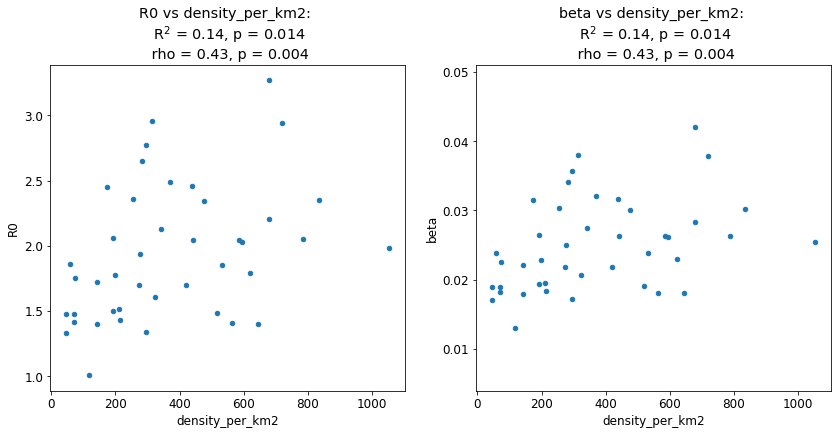

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissementen_ext, 'density_per_km2','R0')
fig_lin_corr(ax2, arrondissementen_ext, 'density_per_km2','beta')


Text(0.5, 1.07, 'Left: all arrondissements - Right : 10 most dense arrondissements')

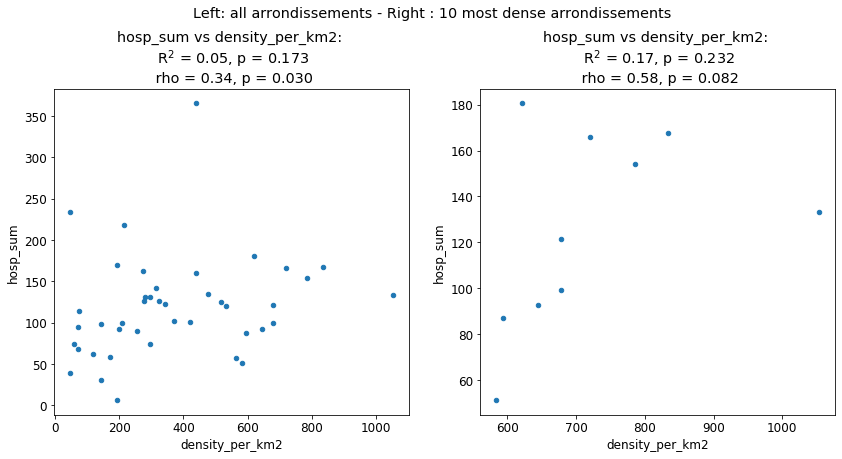

In [241]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissementen_ext, 'density_per_km2','hosp_sum')
fig_lin_corr(ax2, densest_arronds, 'density_per_km2','hosp_sum')
fig.suptitle('Left: all arrondissements - Right : 10 most dense arrondissements', y=1.07)

Text(0.5, 1.07, 'Left: all arrondissements - Right : 10 most dense arrondissements')

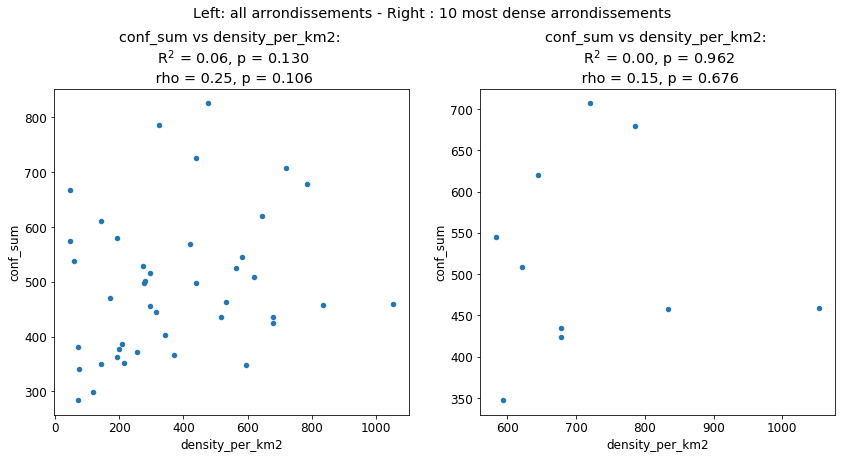

In [242]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissementen_ext, 'density_per_km2','conf_sum')
fig_lin_corr(ax2, densest_arronds, 'density_per_km2','conf_sum')
fig.suptitle('Left: all arrondissements - Right : 10 most dense arrondissements', y=1.07)

Text(0.5, 1.07, 'Left: all arrondissements - Right : 10 most dense arrondissements')

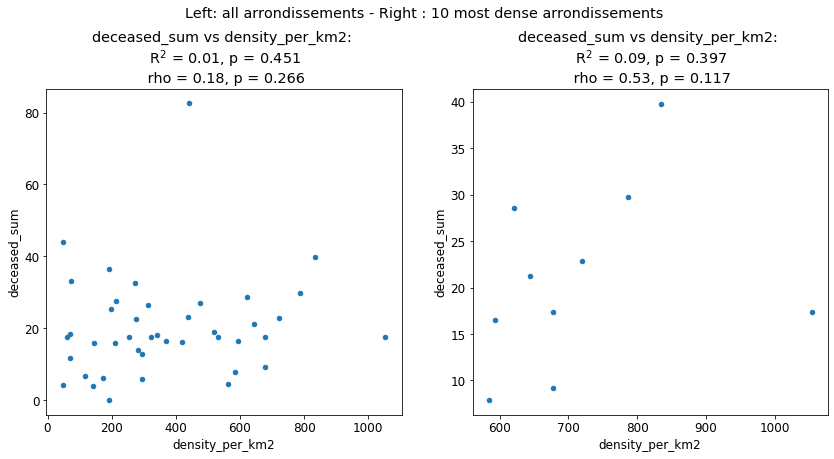

In [243]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissementen_ext, 'density_per_km2','deceased_sum')
fig_lin_corr(ax2, densest_arronds, 'density_per_km2','deceased_sum')
fig.suptitle('Left: all arrondissements - Right : 10 most dense arrondissements', y=1.07)

### Population density binned

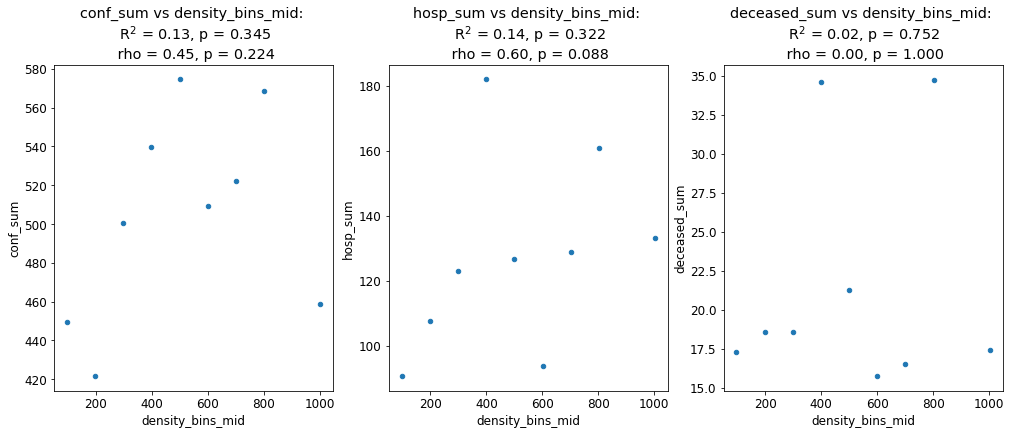

In [244]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,6))
fig_lin_corr(ax1, arrondissement_mean_per_density_bin, 'density_bins_mid','conf_sum')
fig_lin_corr(ax2, arrondissement_mean_per_density_bin, 'density_bins_mid','hosp_sum')
fig_lin_corr(ax3, arrondissement_mean_per_density_bin, 'density_bins_mid','deceased_sum')


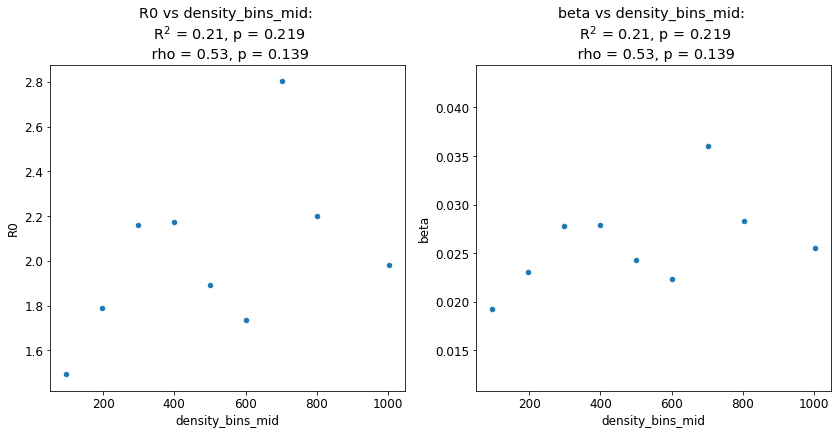

In [245]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissement_mean_per_density_bin, 'density_bins_mid','R0')
fig_lin_corr(ax2, arrondissement_mean_per_density_bin, 'density_bins_mid','beta')


### Demographics

In [219]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
# fig_lin_corr(ax1, arrondissementen_ext, 'median_age','R0')
# fig_lin_corr(ax2, arrondissementen_ext, 'median_age','beta')

In [220]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
# fig_lin_corr(ax1, arrondissementen_ext, 'age_over_60','R0')
# fig_lin_corr(ax2, arrondissementen_ext, 'age_over_60','beta')

In [221]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
# fig_lin_corr(ax1, arrondissementen_ext, 'skewness','R0')
# fig_lin_corr(ax2, arrondissementen_ext, 'skewness','beta')

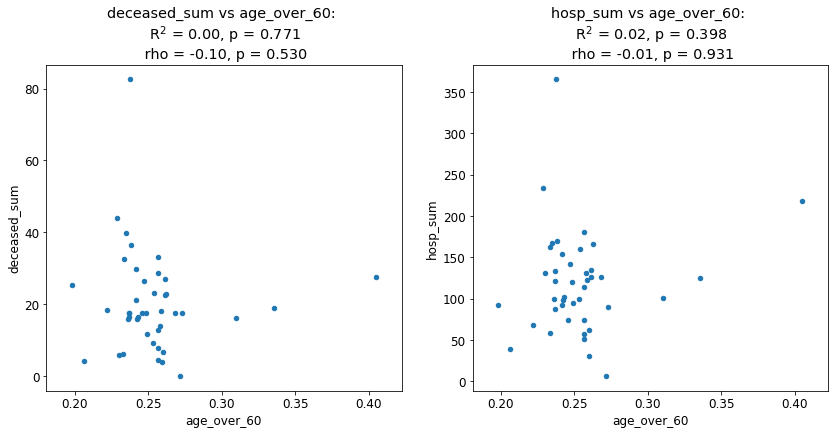

In [272]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissementen_ext, 'age_over_60','deceased_sum')
fig_lin_corr(ax2, arrondissementen_ext, 'age_over_60','hosp_sum')


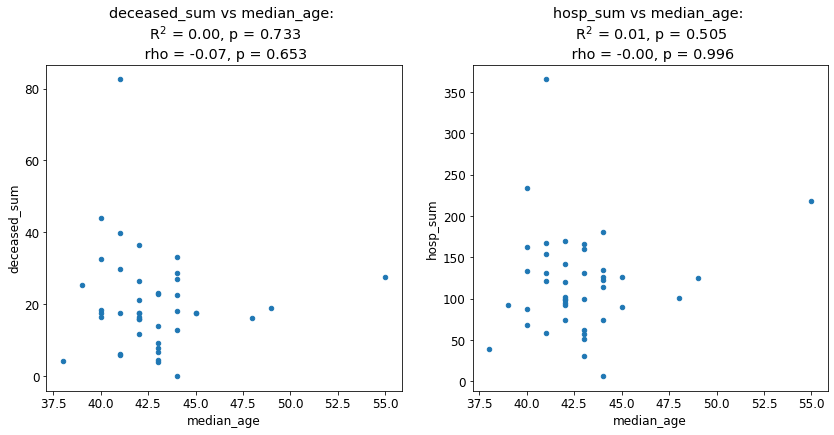

In [273]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissementen_ext, 'median_age','deceased_sum')
fig_lin_corr(ax2, arrondissementen_ext, 'median_age','hosp_sum')


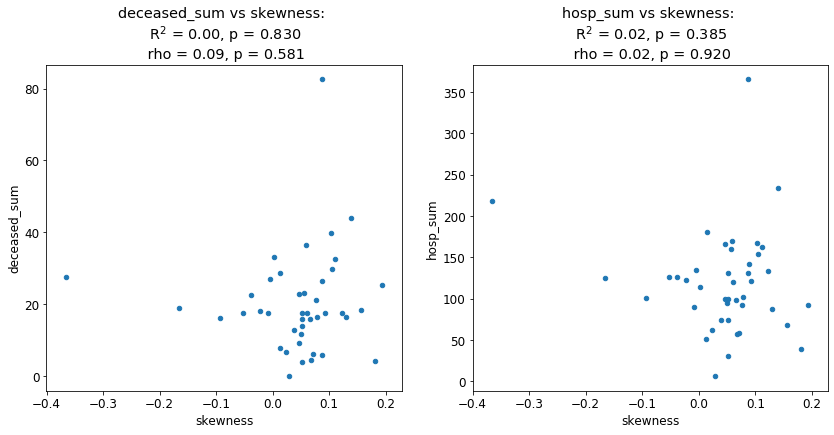

In [274]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissementen_ext, 'skewness','deceased_sum')
fig_lin_corr(ax2, arrondissementen_ext, 'skewness','hosp_sum')


### Grouped per median age

Text(0.5, 1.07, 'Arrondissements grouped per median age')

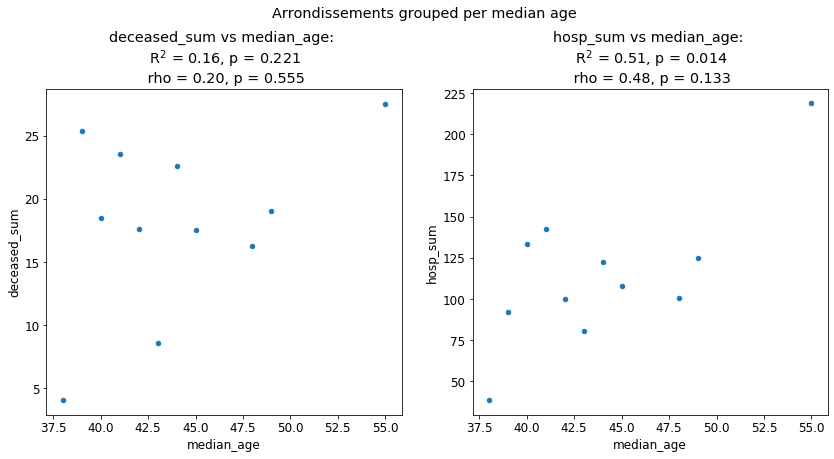

In [277]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, arrondissement_median_per_median_age, 'median_age','deceased_sum')
fig_lin_corr(ax2, arrondissement_median_per_median_age, 'median_age','hosp_sum')
fig.suptitle('Arrondissements grouped per median age', y=1.07)

### Binned per skewness categories

skewness > 0 : more weight in left tail = more young people   
skewness < 0 : more weight in right tail = more old people 

In [298]:
NIS_to_name[arrondissementen_ext[arrondissementen_ext.skewness<-0.3].NIS_arr.item()]

'Arrondissement Veurne'

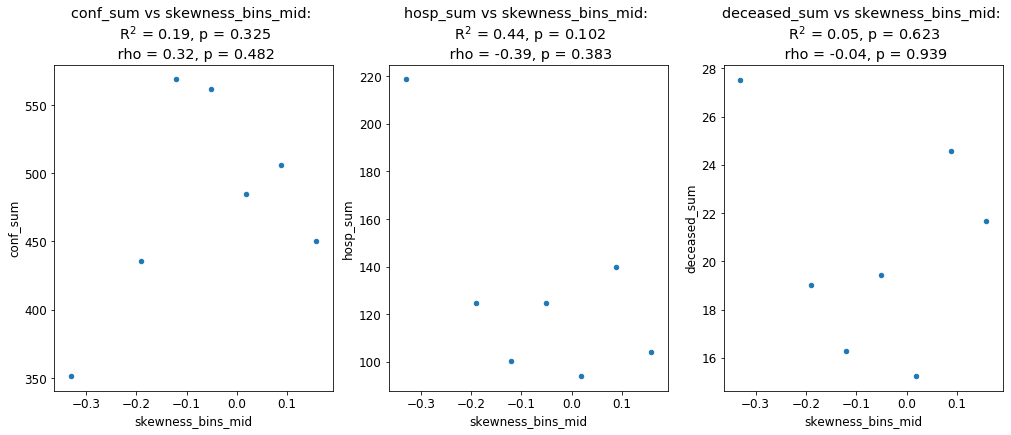

In [278]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,6))
fig_lin_corr(ax1, arrondissement_mean_per_skewness_bin, 'skewness_bins_mid','conf_sum')
fig_lin_corr(ax2, arrondissement_mean_per_skewness_bin, 'skewness_bins_mid','hosp_sum')
fig_lin_corr(ax3, arrondissement_mean_per_skewness_bin, 'skewness_bins_mid','deceased_sum')


## Municipality level

### Population density

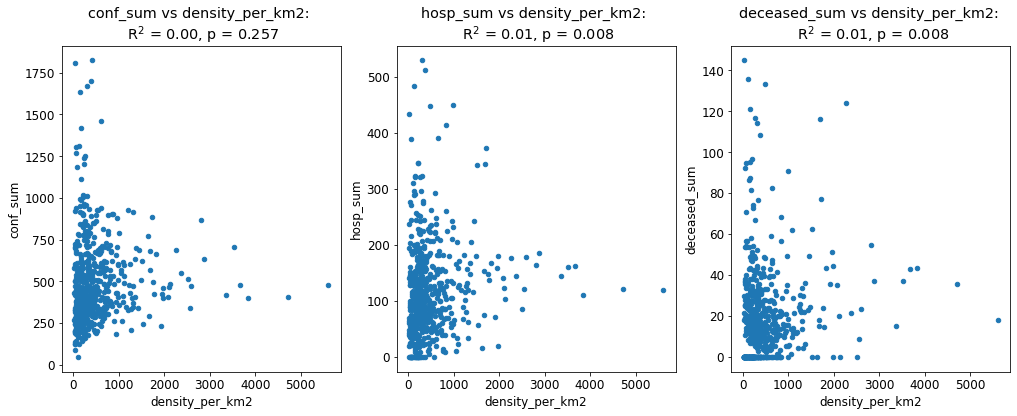

In [146]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,6))
fig_lin_corr(ax1, municipalities_ext, 'density_per_km2','conf_sum')
fig_lin_corr(ax2, municipalities_ext, 'density_per_km2','hosp_sum')
fig_lin_corr(ax3, municipalities_ext, 'density_per_km2','deceased_sum')


### Population density binned

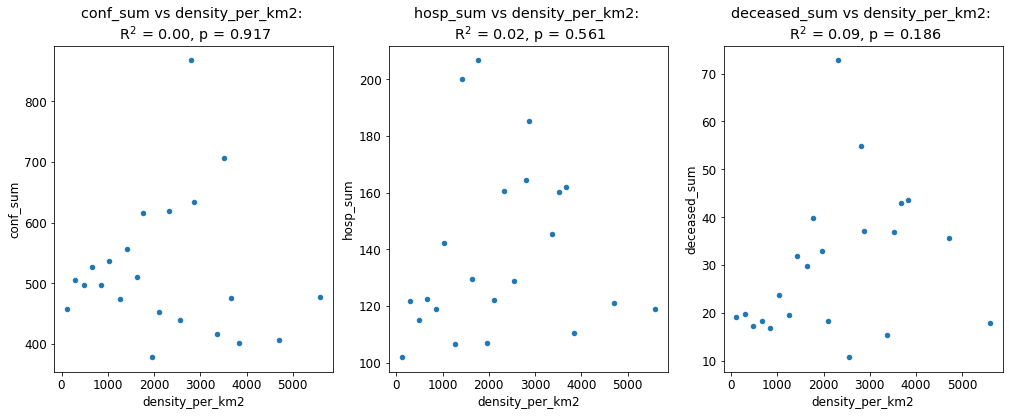

In [154]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,6))
fig_lin_corr(ax1, municipalities_mean_per_density_bin, 'density_per_km2','conf_sum')
fig_lin_corr(ax2, municipalities_mean_per_density_bin, 'density_per_km2','hosp_sum')
fig_lin_corr(ax3, municipalities_mean_per_density_bin, 'density_per_km2','deceased_sum')


### Demographics

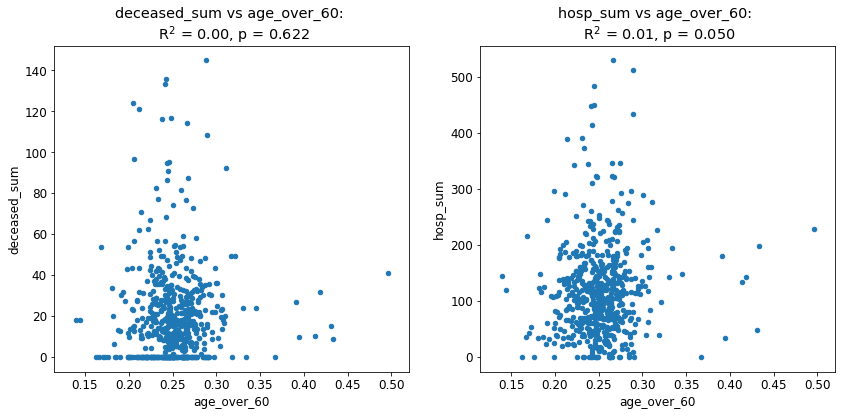

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, municipalities_ext, 'age_over_60','deceased_sum')
fig_lin_corr(ax2, municipalities_ext, 'age_over_60','hosp_sum')


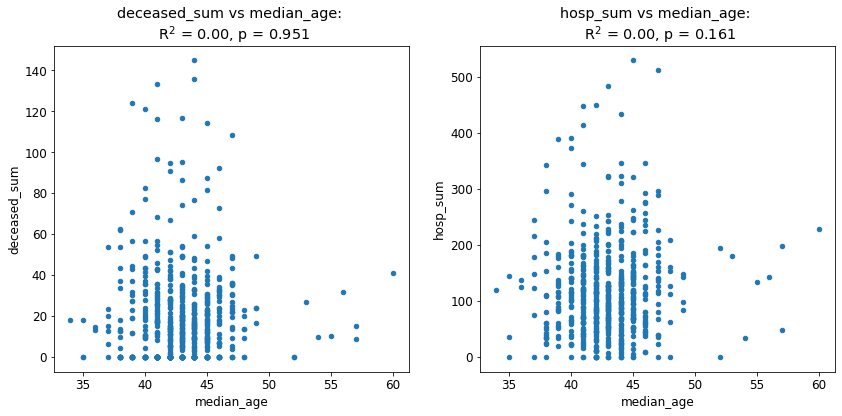

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, municipalities_ext, 'median_age','deceased_sum')
fig_lin_corr(ax2, municipalities_ext, 'median_age','hosp_sum')


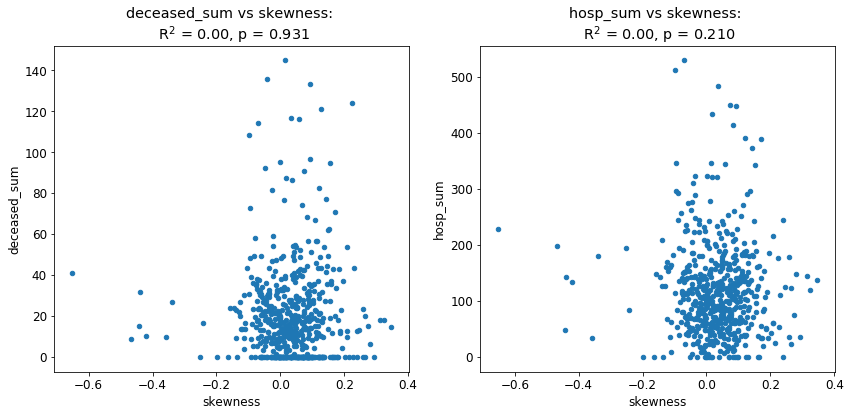

In [234]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, municipalities_ext, 'skewness','deceased_sum')
fig_lin_corr(ax2, municipalities_ext, 'skewness','hosp_sum')


### Grouped per median age

Text(0.5, 1.03, 'Municipalities grouped per median age')

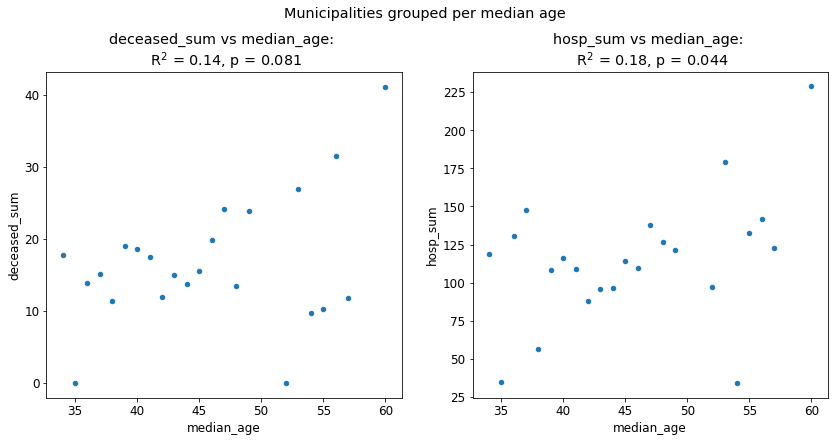

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig_lin_corr(ax1, municipalities_median_per_median_age, 'median_age','deceased_sum')
fig_lin_corr(ax2, municipalities_median_per_median_age, 'median_age','hosp_sum')
fig.suptitle('Municipalities grouped per median age', y=1.03)

### Binned per skewness categories

skewness > 0 : more weight in left tail = more young people   
skewness < 0 : more weight in right tail = more old people 

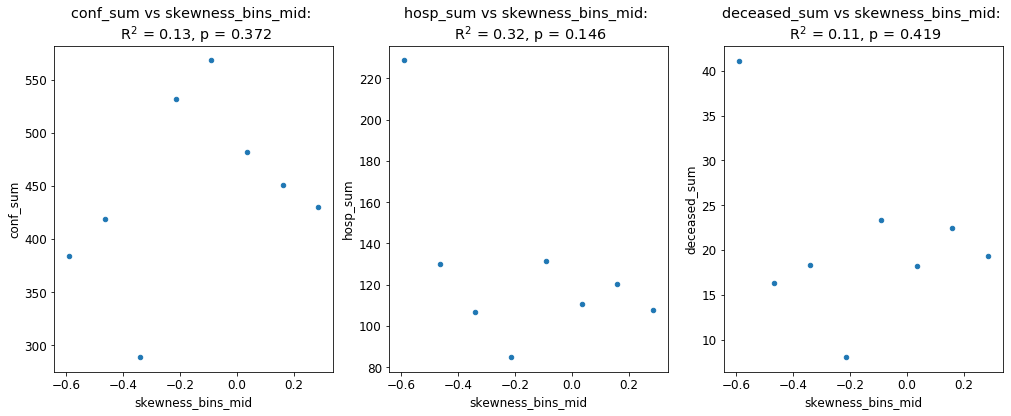

In [235]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,6))
fig_lin_corr(ax1, municipalities_mean_per_skewness_bin, 'skewness_bins_mid','conf_sum')
fig_lin_corr(ax2, municipalities_mean_per_skewness_bin, 'skewness_bins_mid','hosp_sum')
fig_lin_corr(ax3, municipalities_mean_per_skewness_bin, 'skewness_bins_mid','deceased_sum')


# Maps

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
arrondissementen_ext.plot(column='R0', cmap='viridis', ax=ax, legend=True)
ax.set_title('R0 per arrondissement')

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
arrondissementen_ext.plot(column='beta', cmap='viridis', ax=ax, legend=True)
ax.set_title('beta per arrondissement')

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
provinces.plot(ax=ax)